# Label and train notebook YOLO DS-II
- Code to train YOLO model to predict images from T80_kenji

In [ ]:
# Set to true if on COLAB
USING_COLAB = False

In [ ]:
# If using google colab
if USING_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    import os
    # Set to the folder the repo was cloned
    os.chdir("/content/gdrive/MyDrive/Colab Notebooks/STRIKE_YOLO_DRIVE/STRIKE_YOLO")

In [ ]:
! pip install .

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "yolo_type": "YOLOv0_T80kenji_detect",
}

In [2]:
# Folders
# Location of images
images_folder = f"docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/datasets/"
# Location of labels
labels_folder = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"docs/Models/{NOTEBOOK_CONFIG['yolo_type']}/"

In [3]:
# Path for sample image
n_image = 323
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [5]:
import h5py
import os
import shutil
from pathlib import Path
import pandas as pd
from datetime import datetime
import scipy

from matplotlib import pyplot as plt

In [6]:
from PIL import Image
from ultralytics import YOLO
from ultralytics.utils import plotting

# Load modules

In [ ]:
from pipelines.pipelines import ppl_label_YOLOv0, ppl_distribute_images_yolo
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import load_label
from helpers.aux_plotter import gaussians_labelled, plot_grayscale

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [17]:
filename = "docs/Data/T80_kenji.mat"
mat = {}
with h5py.File(filename, "r") as f:
    # Print all keys in the file
    print(list(f.keys()))
    for i_key in f.keys():
        mat.update({i_key: f[i_key][:]})

['T2fit', 'val_fit']


In [18]:
# Renaming as the previous data
mat["F_data"] = mat["T2fit"]
mat["Fit_flux"] = mat["val_fit"]
del mat["T2fit"]
del mat["val_fit"]

In [19]:
# Transposing to match the organization of the previous database
mat["F_data"] = mat["F_data"].T
mat["Fit_flux"] = mat["Fit_flux"].T

In [20]:
# Generate GRID
width = mat["F_data"].shape[1]
length = mat["F_data"].shape[0]
x, y = generate_grid(
    (0, width), (0, length), mat["F_data"].shape[1], mat["F_data"].shape[0]
)

In [21]:
print(mat["F_data"].shape)
print(x.shape)
print(y.shape)

(180, 72, 400)
(180, 72)
(180, 72)


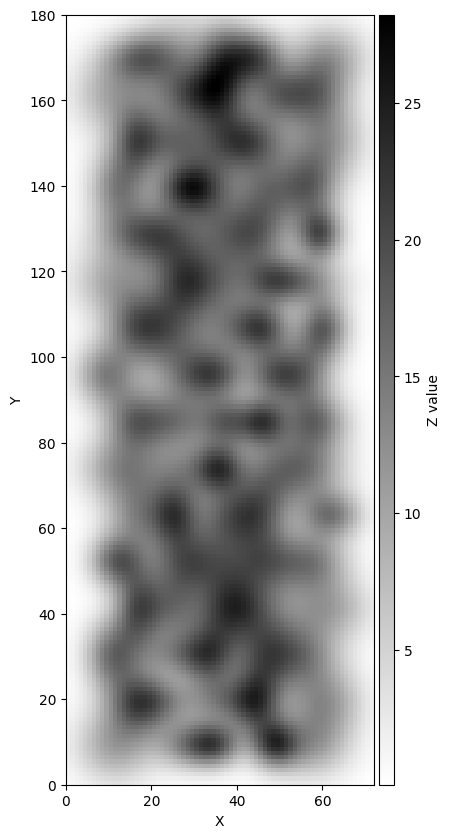

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
plot_grayscale(x, y, mat["F_data"][:, :, 0], ax=ax)

# [ESTIMATION PART I and II]
- Images: 400
- predict_T80kenji

## [ESTIMATION] Pipeline ppl_Yolo - Retrained

### Gaussians labelling for Yolo

In [ ]:
"""Generating labels - Here is the labelling of the images,
not the structuring in folders
"""
if NOTEBOOK_CONFIG["label_mode"]:
    ppl_label_YOLOv0(
        mat["F_data"],
        mat["Fit_flux"],
        f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}",
        remove_out_of_image=True,
        task=NOTEBOOK_CONFIG["task"],
        n_contour_points=None,
        octagon_pol=False,
        image_ranges=NOTEBOOK_CONFIG["image_ranges"],
        image_size=NOTEBOOK_CONFIG["image_size"],
    )

Number of indentifiable Gaussians (center in the image): 80


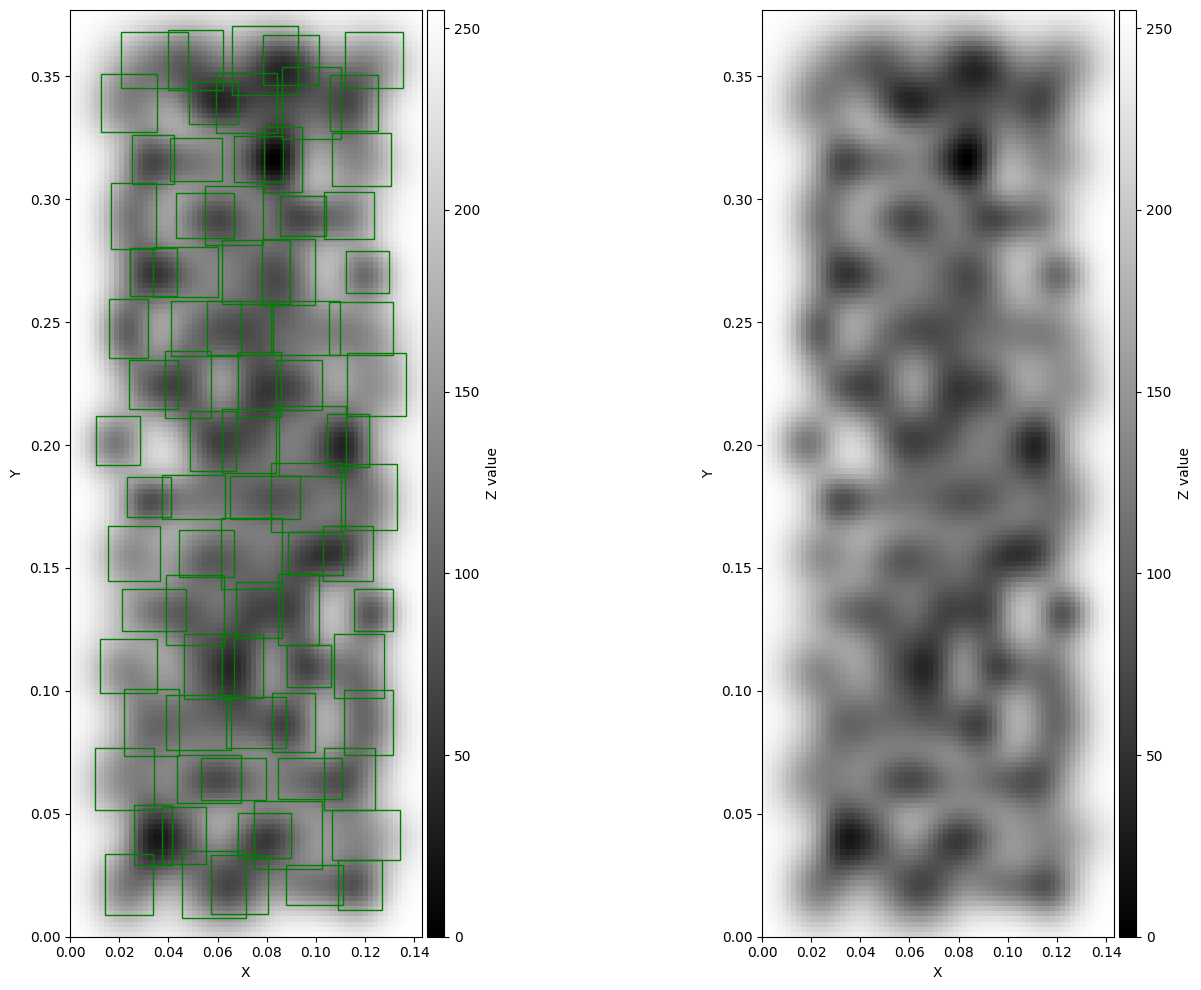

In [ ]:
# Plot ground truth labels
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
x, y, z = gaussians_labelled(
    image_path, label_path, axs[0], task=NOTEBOOK_CONFIG["task"]
)

plot_grayscale(x, y, z, ax=axs[1])
fig.tight_layout()

In [ ]:
# Labels problem in Yolo
lines = load_label(label_path).split("\n")
# Step 2: Split each line into columns using spaces as the separator
labels = [line.split() for line in lines]
df_labels = pd.DataFrame(labels)

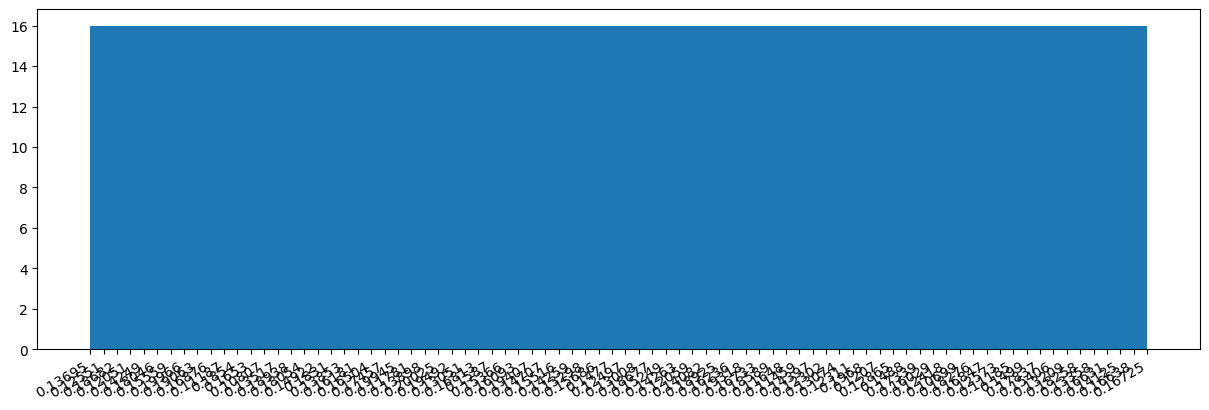

In [ ]:
# In the image distribution of dispersion in x
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_labels[[3]], bins=5)
fig.autofmt_xdate()

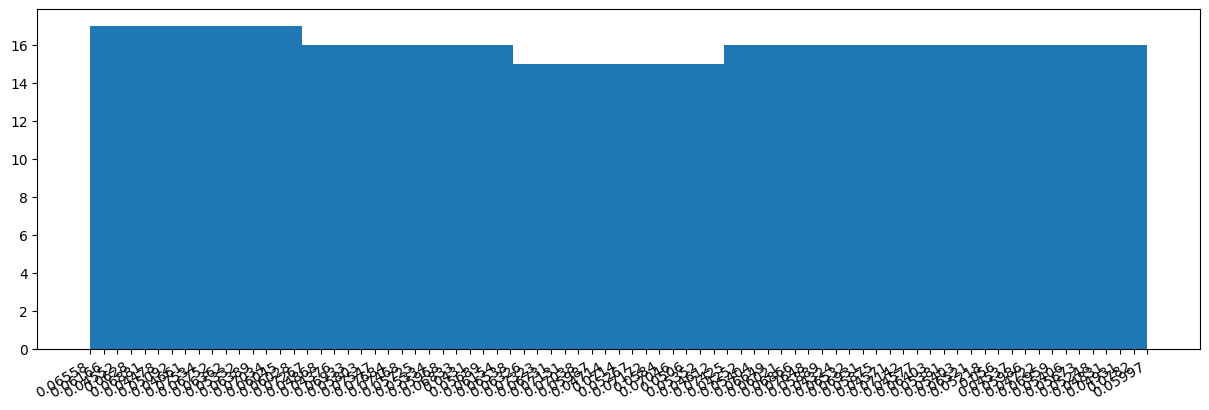

In [ ]:
# In the image distribution of dispersion in y
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_labels[[4]], bins=5)
fig.autofmt_xdate()

### Yolo structure - distribute images in folder

In [ ]:
"""
Image distribution for YoloV0
  - 400 images from T80kenji distributed
  - Labels without  gaussians with center out of the image
"""
range_images = list(range(0, 400))
proportions = {"train": 0.7, "val": 0.2, "test": 0.1}

if NOTEBOOK_CONFIG["label_mode"]:
    ppl_distribute_images_yolo(
        images_folder, labels_folder, yolo_folder, range_images, proportions
    )

In [ ]:
# Config Yolo model to train
yaml_content = f"""
                train: {os.path.join(model_folder, "datasets/train/images")}
                val: {os.path.join(model_folder, "datasets/val/images")}
                test: {os.path.join(model_folder, "datasets/test/images")}
                names: ['gaussian']
                """

if NOTEBOOK_CONFIG["label_mode"]:
    with open(os.path.join(model_folder, "data.yaml"), "w") as f:
        f.write(yaml_content)

### Training model - YOLOv0_T80kenji - 200 epochs

In [ ]:
# Load nano model
model = YOLO("yolov8s.pt")  # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 381MB/s]


In [ ]:
# Train
model_name = "YOLOv0_T80kenji_detect"
if NOTEBOOK_CONFIG["train_mode"]:
    results = model.train(
        device=0,  # "cpu"
        batch=-1,
        patience=100,
        task=NOTEBOOK_CONFIG["task"],
        data=os.path.join(model_folder, "data.yaml"),
        epochs=200,
    )

New https://pypi.org/project/ultralytics/8.0.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_T80kenji_detect/data.yaml, epochs=200, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width

In [ ]:
# Copy results (If in Google Colab)
if NOTEBOOK_CONFIG["train_mode"]:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    shutil.copytree(
        Path("/content/runs/"), Path(f"docs/Models/{model_name}/runs/{timestamp}")
    )

In [ ]:
task = "detect"
plotting.plot_results(f'/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.csv')
image = Image.open(f'/content/runs/{NOTEBOOK_CONFIG['task']}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
image